In [81]:
from pyraysum import prs, Geometry, Model, Control
import numpy as np
import os
import obspy as op
import pandas as pd
from scipy.optimize import dual_annealing, shgo, differential_evolution
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import LinearConstraint, Bounds
import ast
import time
from scipy.stats import pearsonr


In [82]:
# reading the data
def reading_rfs(keyword: str, filters=(0.05, 0.3), corners = 4, sort=None, t_snr_treshold=-10, path_to_data="DATA/waveforms_list.csv") -> tuple:
    """
    Reading RF data by the name of keyword as station code
    inputs:
    keyword: str
        station code
    t_snr_treshold: float
        signal to noise ratio treshold for transverse component (default 0, means no treshold)

    outputs:
    obser: np.array
        observed data in numpy array format
    baz: list
        corresponding back azimuth
    slow: list
        corresponding slowness
    """
    baz = []
    slow = []
    waveforms_list = pd.read_csv("DATA/waveforms_list.csv")
    filtered_files = waveforms_list[waveforms_list['sta_code']==keyword].copy()
    filtered_files = filtered_files[filtered_files['rf_quality'] == 1].copy()
    path = "DATA/RF/"
    npts = 426 * 2   
    dt = 0.2
    obser = np.zeros((len(filtered_files), npts))
    
    # function to calculate signal to noise ratio for transverse component
    def cal_snr_for_transverse(rft: np.array) -> np.array:
        noise = np.mean(rft[:200]**2)
        signal = np.mean(rft[213:263]**2)
        return 10 * np.log10(signal/noise)
    
    idx = 0
    for _, row in filtered_files.iterrows():
        wave_path = os.path.join(path, row['file_name']+".pkl")
        st = op.read(wave_path)
        RFR = st.select(channel="RFR")[0].filter('bandpass', freqmin=filters[0], freqmax=filters[1], corners=corners, zerophase=True).data
        RFT = st.select(channel="RFT")[0].filter('bandpass', freqmin=filters[0], freqmax=filters[1], corners=corners, zerophase=True).data
        #check if the signal to noise ratio is above the treshold
        if cal_snr_for_transverse(RFT) > t_snr_treshold:
            baz.append(st[0].stats.baz)
            slow.append(st[0].stats.slow)
            RFR = RFR #/ np.max(np.abs(RFR))
            RFT = RFT #/ np.max(np.abs(RFT))
            obser[idx, :426] = RFR
            obser[idx, 426:] = RFT
            idx += 1
    obser = obser[:idx, :]
    # sorting based on back azimuth or slowness
    if sort != None:
        zipped = list(zip(obser, baz, slow))
        if sort == "baz":
            zipped.sort(key=lambda x: x[1])
        elif sort == "slow":
            zipped.sort(key=lambda x: x[2])
        obser, baz, slow = zip(*zipped)
    obser = np.array(obser)
    return obser, baz, slow



# reading the model
def read_model(path_to_models, layer):
    """
    Reading the initials bounds and values
    Inputs:
        path_to_models: str: path to the models
        layer: int: layer number
    Outputs:
        bounds: list: bounds of the model
        fixed_vales: list: fixed values of the model
        mask: np.array: mask for the non-fixed values
    """
    bounds = pd.read_csv(os.path.join(path_to_models, "bounds.csv"))
    fixed_vales = pd.read_csv(os.path.join(path_to_models, "fixed_values.csv"))
    bounds = bounds[bounds["layer_code"] == layer].drop(columns=["layer_code"])
    fixed_vales = fixed_vales[fixed_vales["layer_code"] == layer].drop(columns=["layer_code"])
    
    #fix a bug
    # if fixed_vales.loc[len(fixed_vales.ani)-1, "ani"] == None:
    #     fixed_vales.loc[len(fixed_vales.ani)-1, "ani"]=np.nan
    
    bounds = bounds.values.flatten()
    # create a mask for the non-fixed values
    mask = pd.notna(bounds)
    bounds = [ast.literal_eval(i) for i in bounds if str(i) != 'nan']
    return bounds, fixed_vales, mask

def pyraysum_func(baz, slow, thickn, rho, vp, vs, dip, strike,
                  plunge, trend, ani, npts, dt) -> tuple:
    flag = [1 if ani[i]==0 else 0 for i in range(len(ani))]
    model = Model(thickn, rho, vp, vs=vs, strike=strike,
                  dip=dip, plunge=plunge, trend=trend, ani=ani, flag=flag)
    geom = Geometry(baz, slow)
    rc = Control(wvtype="P", rot="RTZ", mults=2, verbose=False,
                 npts=npts*1, dt=dt, align=1, shift=5)
    result = prs.run(model, geom, rc, rf=True)
    result.filter('rfs', 'lowpass', freq=1., zerophase=True, corners=2)
    return result

def predict(model: pd.DataFrame, baz, slow, filters=(0.05, 0.3), corners=4):
    result = pyraysum_func(baz, slow, model["thickn"], model["rho"], model["vp"], model["vs"], model["dip"],
                                     model["strike"], model["plunge"], model["trend"], model["ani"], 3*426, 0.2)
    #lower number of samples would be problematic and that is why we produce longer signal and then reduce it
    pred = np.zeros((len(result), 2*426)) 
    pred_r = np.zeros((len(result), 3*426))
    pred_t = np.zeros((len(result), 3*426))

    for idx, i in enumerate(result):
        RFR = i[1][0].filter('bandpass', freqmin=filters[0], freqmax=filters[1], corners=corners, zerophase=True).data
        RFT = i[1][1].filter('bandpass', freqmin=filters[0], freqmax=filters[1], corners=corners, zerophase=True).data
        pred_r[idx, :] = RFR #/ np.max(np.abs(RFR))
        pred_t[idx, :] = RFT #/ np.max(np.abs(RFT))
    #making more samples to reduce the effect of the edges
    pred_r = pred_r[:, 426:2*426]
    pred_t = pred_t[:, 426:2*426]
    pred[:, :426], pred[:, 426:] = pred_r, pred_t
        #reducing the length of the data to 426
    return pred

def cost_func(variables, fixed_values, mask, obser, baz, slow, layer):
    """
    """
    keys = fixed_values.keys()
    fixed_values = fixed_values.values.flatten()
    fixed_values[mask] = variables
    model = fixed_values.reshape(layer, 9)
    model = pd.DataFrame(model, columns=keys)
    pred = predict(model, baz, slow)

    # # Mean Squared Error (MSE) --> eval = 4/5
    # loss = np.mean((obser - pred) ** 2)
    
    # # Mean Absolute Error (MAE) --> eval = 3/5
    # loss = np.mean(np.abs(obser - pred))
    
    # # Mean Absolute Percentage Error (MAPE) --> eval = 1/5
    # loss = np.mean(np.abs((obser - pred) / obser)) * 100
    
    # # Log-Cosh Loss --> eval = 3/5
    # loss = np.mean(np.log(np.cosh(obser - pred)))
    
    # # Symmetric Mean Absolute Percentage Error (sMAPE) --> eval = 3/5
    # loss = np.mean(2 * np.abs(pred - obser) / (np.abs(pred) + np.abs(obser))) * 100
    
    # # Cosine Similarity Loss --> eval = 0/5
    # from sklearn.metrics.pairwise import cosine_similarity
    # loss = 1 - cosine_similarity([obser], [pred])[0][0]

    # # Pearson Correlation Coefficient --> eval = 3/5
    # loss = 1 - pearsonr(obser.flatten(), pred.flatten())[0]

    # # Normalized Mean Squared Error (NMSE) --> eval = 4/5
    # loss = np.mean((obser - pred) ** 2) / np.mean(obser ** 2)

    # Correlation Coefficient --> eval = 4/5
    # loss = 1 - np.corrcoef(obser.flatten(), pred.flatten())[0, 1]


    # # Correlation Coefficient --> eval = 5/5
    # corr_coef_obs_and_pred = np.corrcoef(obser.flatten(), pred.flatten())[0, 1]
    # corr_coef_obs = np.corrcoef(obser.flatten(), obser.flatten())[0, 1]
    # corr_coef_pred = np.corrcoef(pred.flatten(), pred.flatten())[0, 1]
    # loss_all = 1 - corr_coef_obs_and_pred/(corr_coef_obs*corr_coef_pred)**0.5

    # correlation coefficient for Radial
    corr_coef_obs_and_pred_r = np.corrcoef(obser[:, :426].flatten(), pred[:, :426].flatten())[0, 1]
    corr_coef_obs_r = np.corrcoef(obser[:, :426].flatten(), obser[:, :426].flatten())[0, 1]
    corr_coef_pred_r = np.corrcoef(pred[:, :426].flatten(), pred[:, :426].flatten())[0, 1]
    loss_r = 1 - corr_coef_obs_and_pred_r/(corr_coef_obs_r*corr_coef_pred_r)**0.5

    # correlation coefficient for Transverse
    corr_coef_obs_and_pred_t = np.corrcoef(obser[:, 426:].flatten(), pred[:, 426:].flatten())[0, 1]
    corr_coef_obs_t = np.corrcoef(obser[:, 426:].flatten(), obser[:, 426:].flatten())[0, 1]
    corr_coef_pred_t = np.corrcoef(pred[:, 426:].flatten(), pred[:, 426:].flatten())[0, 1]
    loss_t = 1 - corr_coef_obs_and_pred_t/(corr_coef_obs_t*corr_coef_pred_t)**0.5
    
    return np.mean([3*loss_t, loss_r])/4

def optimize_model(bounds, fixed_values, mask, obser, baz, slow, layer, maxiter=1000):
    result = differential_evolution(cost_func,
                                    bounds,
                                    args=(fixed_values, mask, obser,
                                          baz, slow, layer),
                                    maxiter=maxiter,
                                    disp=True,
                                    updating="deferred")
    return result
    

def save_inv_summary(results, station, layer, data_size, delta_time):
    summary = {"data size": data_size, "error": results.fun, "number of iterations": results.nit, "number of function evaluation": results.nfev, "processing time": delta_time}
    summary_list = [list(summary.keys()), list(summary.values())]
    with open(f"inv/results/{station}/summary_{layer}.txt", "w") as f:
        for i in range(len(summary_list[0])):
            f.write(f"{summary_list[0][i]}: {summary_list[1][i]:.2f}\n")
    return None

Control Block

In [83]:
station = "BULN"
layer = 3
t_snr_treshold = 7.0 #signal to noise ratio treshold for transverse component
filters = (0.05, 0.30)
corners = 4
path_to_data = "DATA/RF"
path_to_models = "inv/initial"
os.makedirs(f"inv/results/{station}", exist_ok=True)
#reading RFs
obser, baz, slow = reading_rfs(station, t_snr_treshold=t_snr_treshold, sort="baz", filters=filters, corners=corners)
print("Station:", station,"- Observation Data Size:", obser.shape)
# reading the model bounds and fixed values
bounds, fixed_values, mask = read_model(path_to_models, layer)

Station: BULN - Observation Data Size: (6, 852)


Geometry Plot

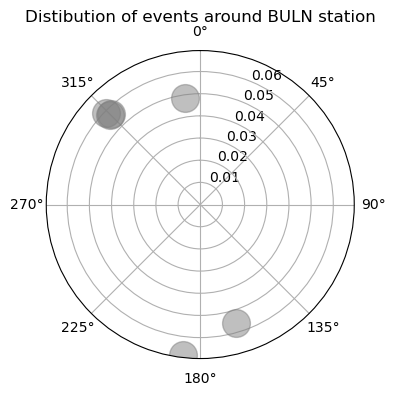

In [84]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
ax.plot(np.array(baz)*np.pi/180, slow, marker='o', linestyle='', color='grey', markersize=20, alpha=0.5, linewidth=1)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.grid(True)
ax.set_title(f"Distibution of events around {station} station", va='top')
plt.show()
fig.savefig(f"inv/results/{station}/geometry.png")

In [85]:
start_time = time.time()
results = optimize_model(bounds, fixed_values, mask, obser, baz, slow, layer, maxiter=4)
end_time = time.time()
save_inv_summary(results, station, layer, obser.shape[0], end_time-start_time)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 27

In [ ]:
flatten_x = fixed_values.values.flatten()
flatten_x[mask] = results.x
flatten_x = flatten_x.reshape(layer, 9)
flatten_x = pd.DataFrame(flatten_x, columns=fixed_values.columns)
flatten_x.to_csv(f"inv/results/{station}/model_{station}_{layer}_layer.csv", index=False)
flatten_x

,thickn,rho,vp,vs,dip,strike,plunge,trend,ani
0,28621.414001,2985.198409,6863.188596,3792.724741,0.000000,0.000000,44.912490,79.069400,6.725081
1,6455.447476,2807.331346,6934.111742,4009.453857,2.891783,88.926567,9.972502,180.580204,4.196297
2,0.000000,3500.000000,8100.000000,4500.000000,4.914173,139.757252,0.000000,0.000000,0.000000


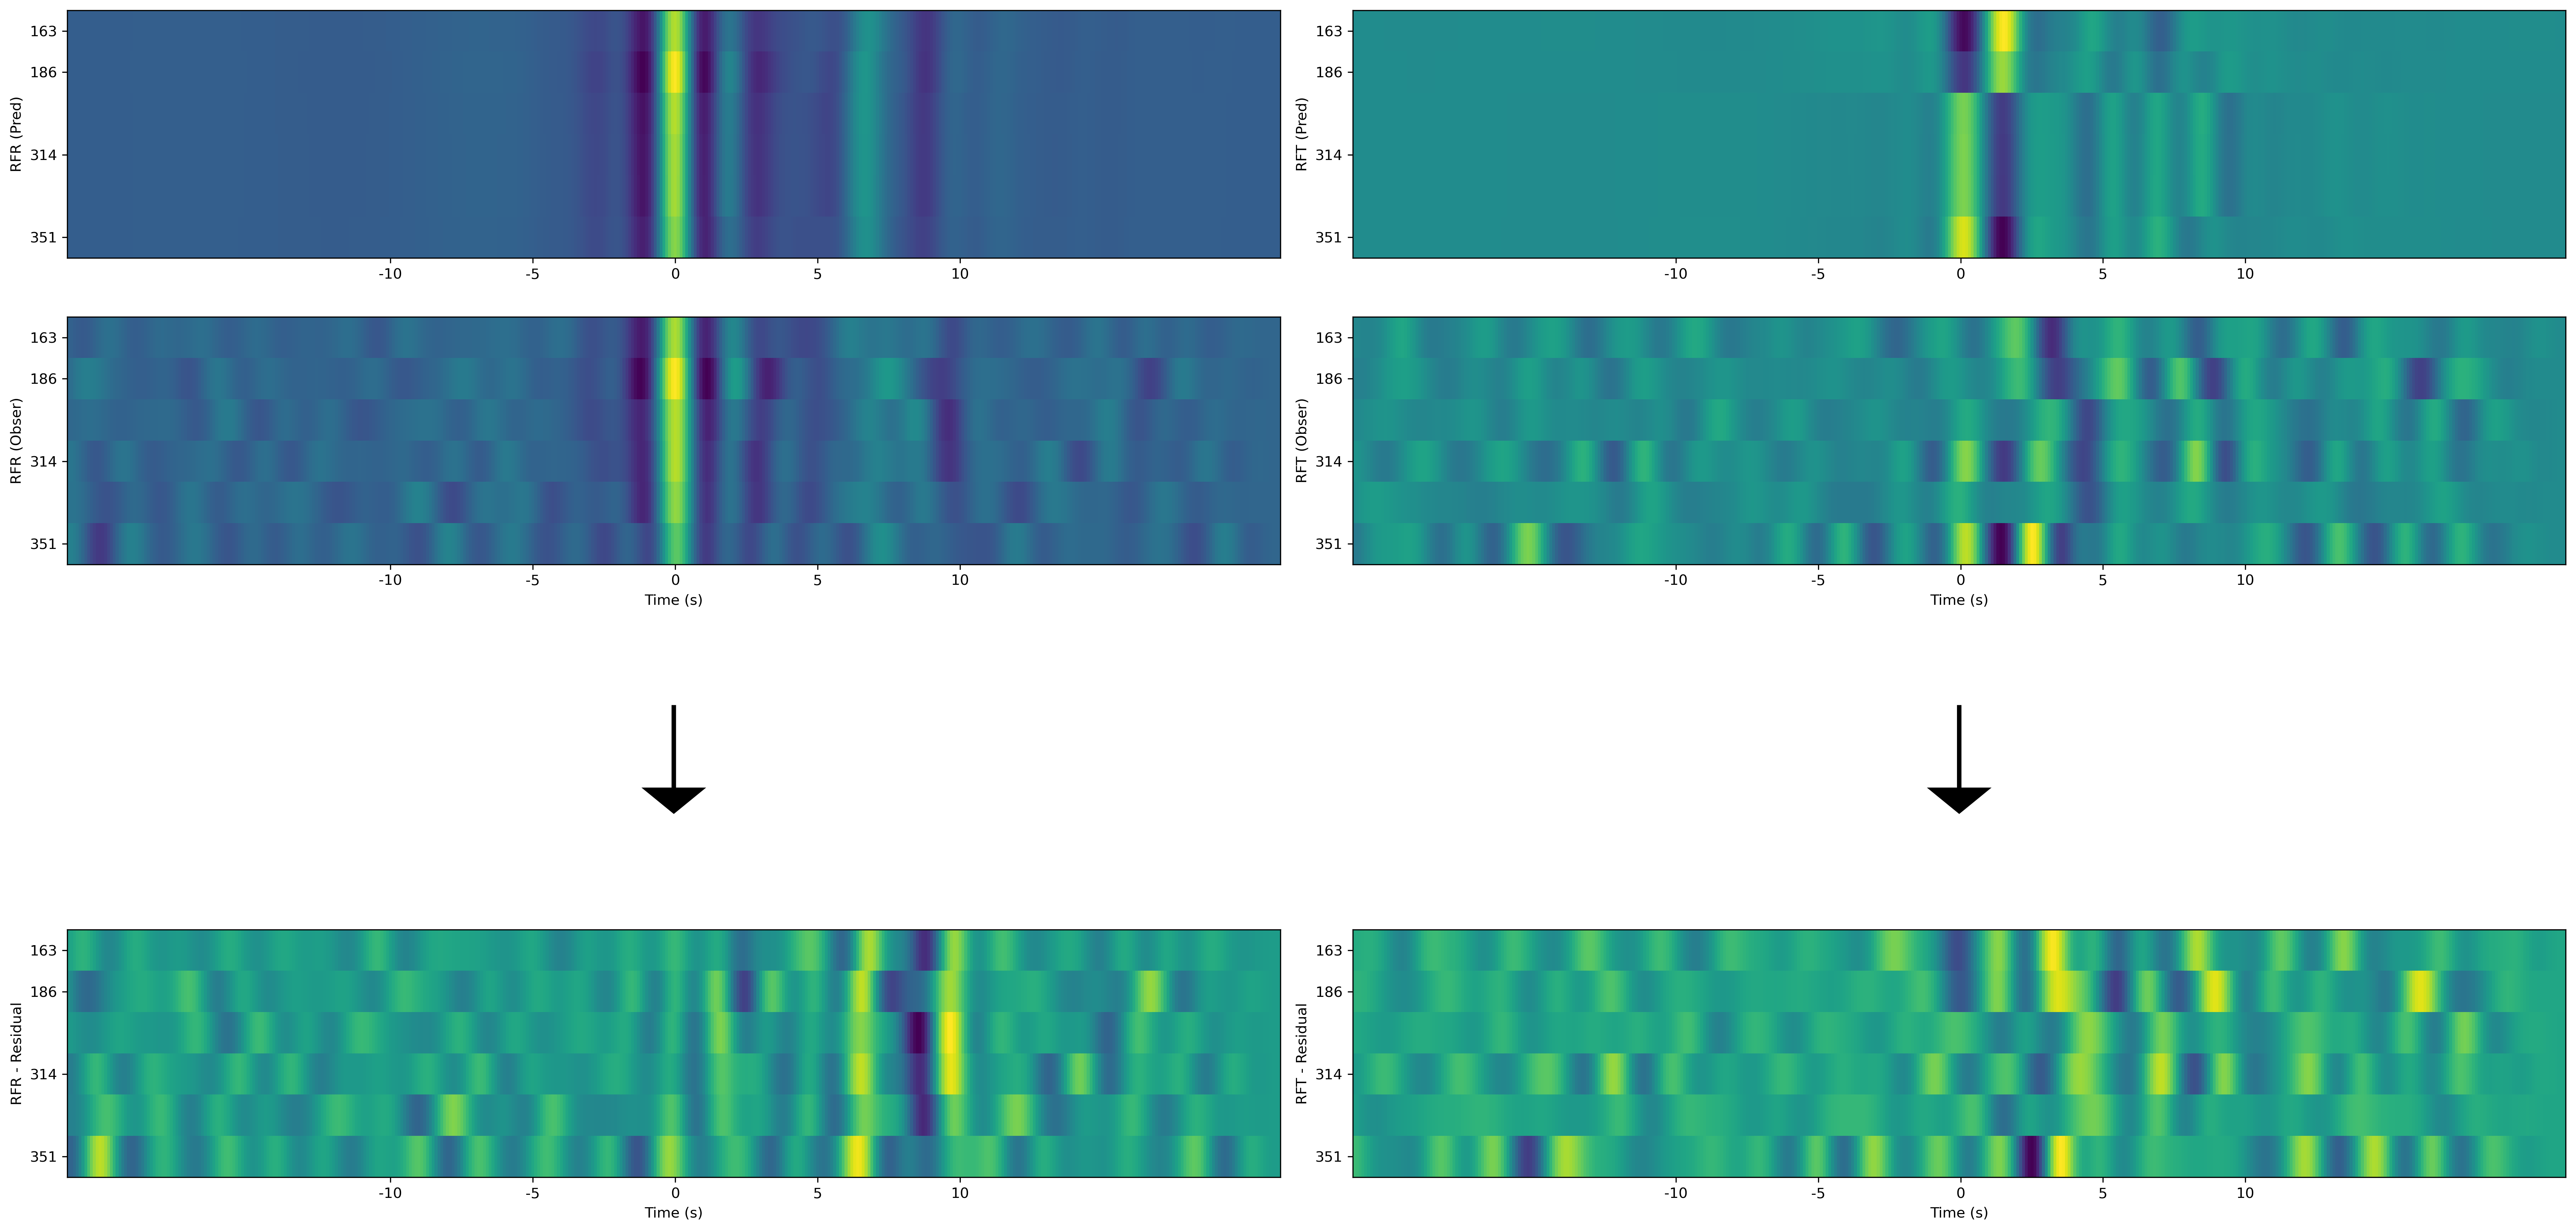

In [ ]:
import matplotlib.pyplot as plt
time = np.arange(-213/5, 213/5, 5)
pred_data = predict(flatten_x, baz, slow)
fig_main = plt.figure(figsize=(25, 12), dpi=300)
row, col = 4, 2
y_val = np.int_(np.linspace(0, pred_data.shape[0]-1, 4))

###################
plt.subplot(row, col, 1)
plt.imshow(pred_data[:,0:426], aspect="auto")
plt.xticks(np.array([113, 163, 213, 263, 313]), [-10, -5, 0, 5, 10])
plt.yticks(y_val, [int(baz[y_val[0]]), int(baz[y_val[1]]), 
                   int(baz[y_val[2]]), int(baz[y_val[3]])])
plt.ylabel("RFR (Pred)")
###################
plt.subplot(row, col, 3)
plt.imshow(obser[:,0:426], aspect="auto")
plt.ylabel("RFR (Obser)")
plt.xlabel("Time (s)")
plt.xticks(np.array([113, 163, 213, 263, 313]), [-10, -5, 0, 5, 10])
plt.yticks(y_val, [int(baz[y_val[0]]), int(baz[y_val[1]]), 
                   int(baz[y_val[2]]), int(baz[y_val[3]])])
###################
plt.subplot(row, col, 2)
plt.imshow(pred_data[:,426:], aspect="auto")
plt.ylabel("RFT (Pred)")
plt.xticks(np.array([113, 163, 213, 263, 313]), [-10, -5, 0, 5, 10])
plt.yticks(y_val, [int(baz[y_val[0]]), int(baz[y_val[1]]), 
                   int(baz[y_val[2]]), int(baz[y_val[3]])])
###################
plt.subplot(row, col, 4)
plt.imshow(obser[:,426:], aspect="auto")
plt.ylabel("RFT (Obser)")
plt.xticks(np.array([113, 163, 213, 263, 313]), [-10, -5, 0, 5, 10])
plt.yticks(y_val, [int(baz[y_val[0]]), int(baz[y_val[1]]), 
                   int(baz[y_val[2]]), int(baz[y_val[3]])])
plt.xlabel("Time (s)")
###################
plt.subplot(row, col, 5)
plt.arrow(0, 0, 0, -1, head_width=0.02, head_length=0.3, fc='k', ec='k')
plt.xlim(-0.2, 0.2)
plt.ylim(-2, 1)
plt.axis('off')
plt.subplot(row, col, 6)
plt.arrow(0, 0, 0, -1, head_width=0.02, head_length=0.3, fc='k', ec='k')
plt.xlim(-0.2, 0.2)
plt.ylim(-2, 1)
plt.axis('off')
###################
plt.subplot(row, col, 7)
plt.imshow(pred_data[:,0:426]-obser[:,0:426], aspect="auto")
plt.ylabel("RFR - Residual")
plt.xticks(np.array([113, 163, 213, 263, 313]), [-10, -5, 0, 5, 10])
plt.yticks(y_val, [int(baz[y_val[0]]), int(baz[y_val[1]]), 
                   int(baz[y_val[2]]), int(baz[y_val[3]])])
plt.xlabel("Time (s)")
###################
plt.subplot(row, col, 8)
plt.imshow(pred_data[:,426:]-obser[:,426:], aspect="auto")
plt.ylabel("RFT - Residual")
plt.xticks(np.array([113, 163, 213, 263, 313]), [-10, -5, 0, 5, 10])
plt.yticks(y_val, [int(baz[y_val[0]]), int(baz[y_val[1]]), 
                   int(baz[y_val[2]]), int(baz[y_val[3]])])
plt.xlabel("Time (s)")
###################
plt.tight_layout()
fig_main.savefig(f"inv/results/{station}/imageofwaves_{station}_{layer}_layer.png")

plt.show()


Model

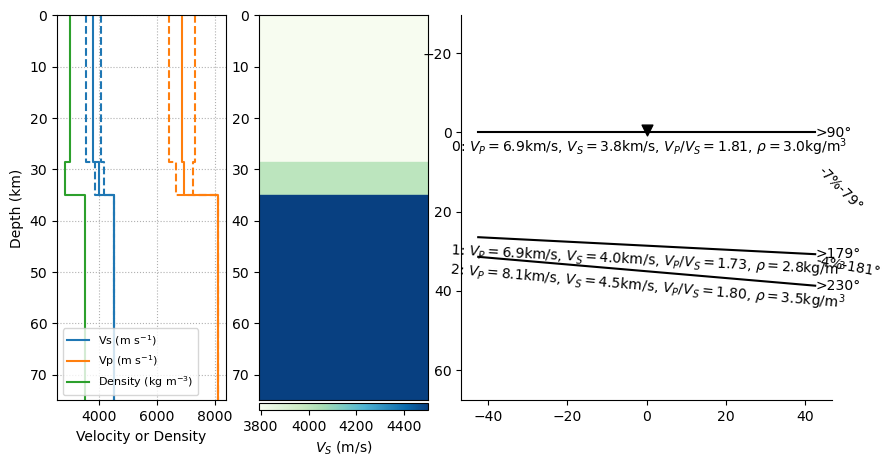

In [ ]:
model = Model(flatten_x["thickn"], flatten_x["rho"], flatten_x["vp"], vs=flatten_x["vs"],
              strike=flatten_x["strike"], dip=flatten_x["dip"], plunge=flatten_x["plunge"],
              trend=flatten_x["trend"], ani=flatten_x["ani"],
              flag=[1 if flatten_x["ani"][i]==0 else 0 for i in range(len(flatten_x["ani"]))])
fig_model = model.plot()
plt.show()
fig_model.savefig(f"inv/results/{station}/model_{station}_{layer}_layer.png")

Plotting Waveforms

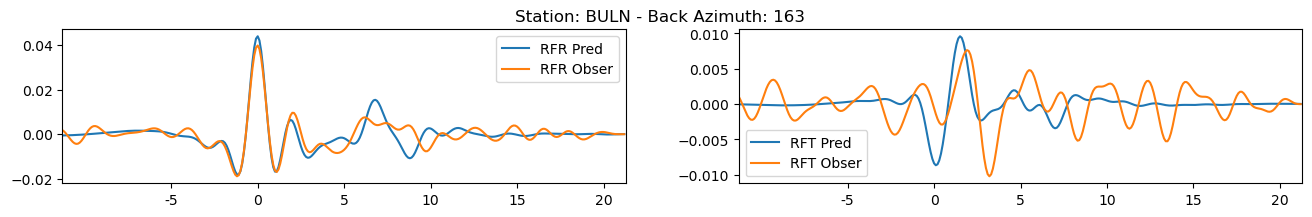

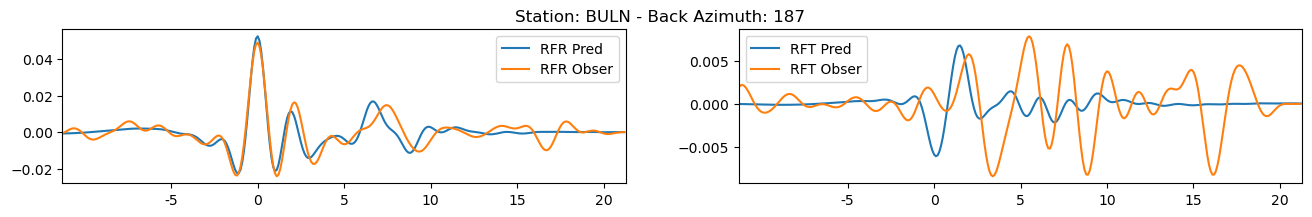

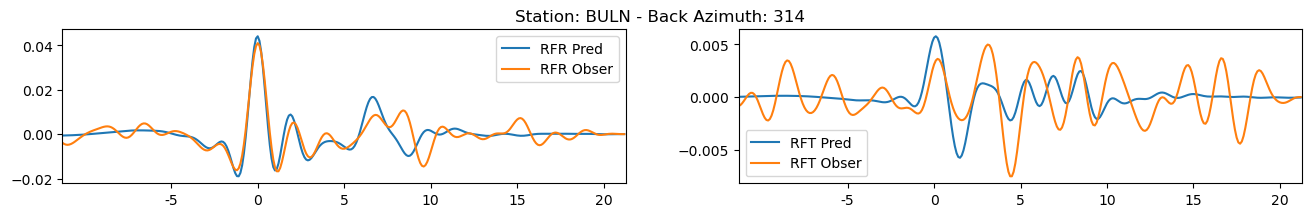

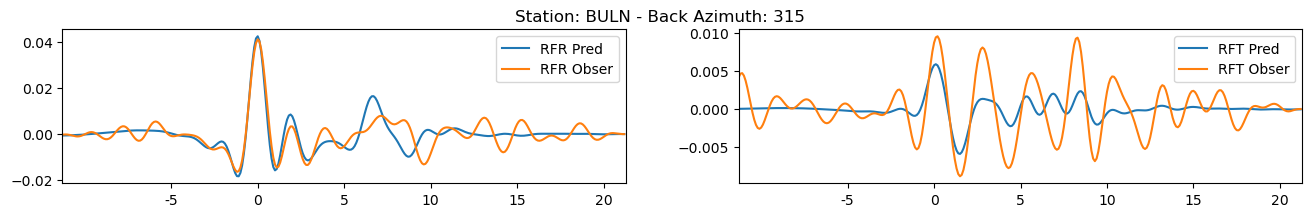

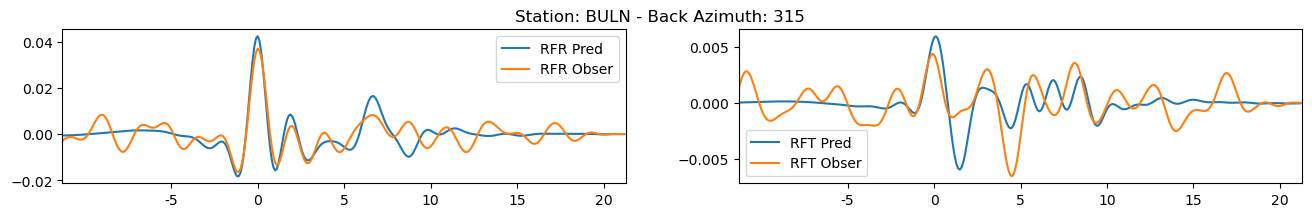

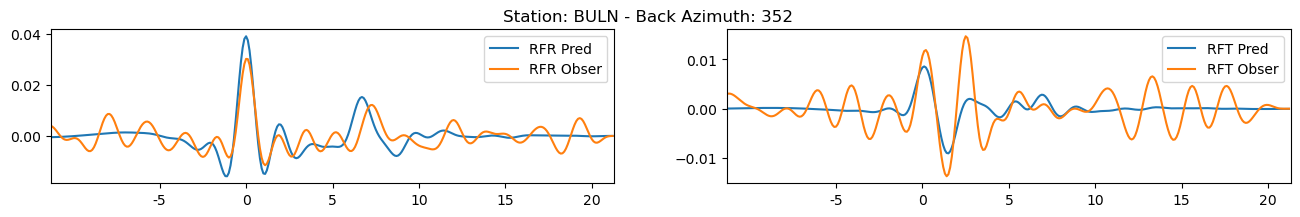

In [ ]:
data_length = pred_data.shape[0]
os.makedirs(f"inv/results/{station}/waveforms", exist_ok=True)

for i, j, z in zip(pred_data, obser, baz):
    fig, ax = plt.subplots(1, 2, figsize=(16, 2))
    ax[0].plot(i[0:426], label="RFR Pred")
    ax[0].plot(j[0:426], label="RFR Obser")
    ax[0].set_xticks([163, 213, 263, 313, 363, 413], [-5, 0, 5, 10, 15, 20])
    ax[0].legend()
    ax[0].set_xlim(100, 426)

    ax[1].plot(i[426:], label="RFT Pred")
    ax[1].plot(j[426:], label="RFT Obser")
    ax[1].set_xticks([163, 213, 263, 313, 363, 413], [-5, 0, 5, 10, 15, 20])
    ax[1].legend()
    ax[1].set_xlim(100, 426)
    fig.suptitle(f"Station: {station} - Back Azimuth: {z:.0f} ")
    plt.show()
    fig.savefig(f"inv/results/{station}/waveforms/layer_{layer}_baz{z:.0f}.png")